In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from itertools import product
from sklearn.metrics import mean_absolute_percentage_error as mape
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

##### Task 
1. Gather data for the number of marriages, the number of divorces and the number of births in a city or a country during a period that you consider sufficient for forecasting.
2. Visualise the time series. Use time series decomposition to extract the trend and seasonal components. Divide the data into train and test sets.
3. Fit a SARIMA model.
4. Could you think of external variables that have impact on any of the three series? Fit a SARIMAX model.
5. Is there inter-dependance between any of these three time series? If not, try to find another time series that is inter-dependant with the number of births, for example. Fit a VARMAX model.
6. Choose and apply two baseline models.
7. Make forecasts and plot them.
8. Compare the performance of the developed models: baselines, SARIMA, SARIMAX and VARMAX. Select an appropriate error metric.
9. Make conclusions.
10. Submit your work.

##### 1) Gather data for the number of marriages, the number of divorces and the number of births in a city or a country during a period that you consider sufficient for forecasting.

'data_final.csv' containes monthly information about marriages, divorces and births in Sweden from january 2000 to september 2023 The task is to predict all the three parameters for october-december 2023.

links to the files: 
'data_final' : https://drive.google.com/file/d/1VzoGvipvmBApkOJsKBNFSR2q6u9rgFtK/view?usp=drive_link
'gdp': https://drive.google.com/file/d/1WpyBycIfTP4Q2dx9T8SLTPsFDFvNb42s/view?usp=drive_link

In [2]:
#reading the created file
data = pd.read_csv('data_final.csv')

In [3]:
data.head()

,date,marriages,divorces,births
0,2000-1,1804,1336,7306
1,2000-2,1610,2041,7441
2,2000-3,1799,2104,8001
3,2000-4,2477,1822,7931
4,2000-5,3565,1854,8186


##### 2) Visualising the time series. Use time series decomposition to extract the trend and seasonal components. Divide the data into train and test sets.

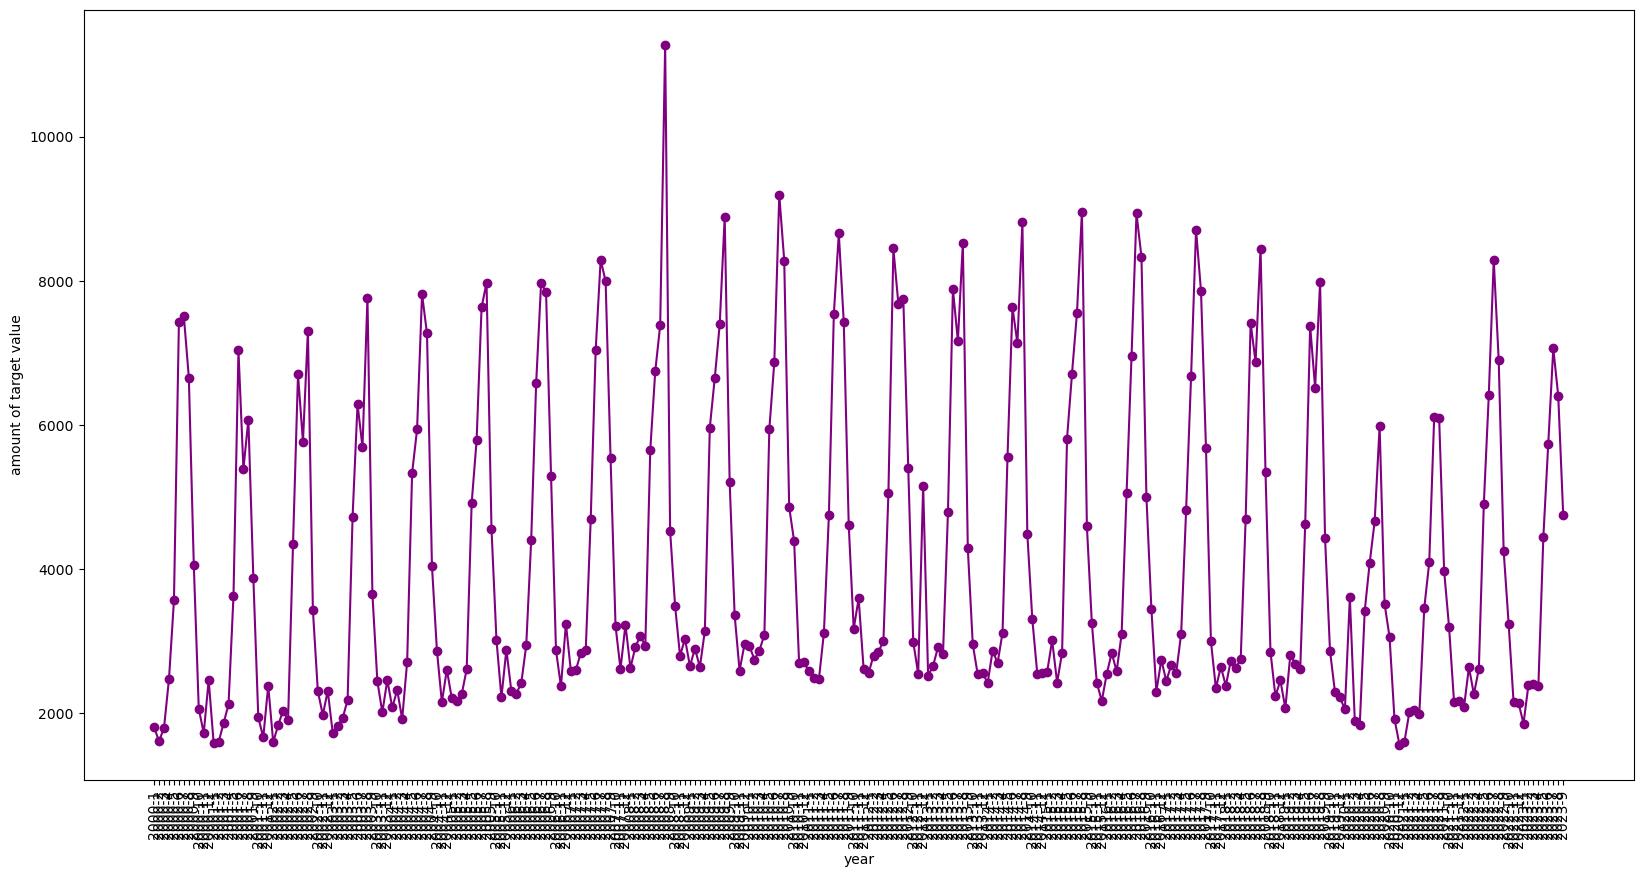

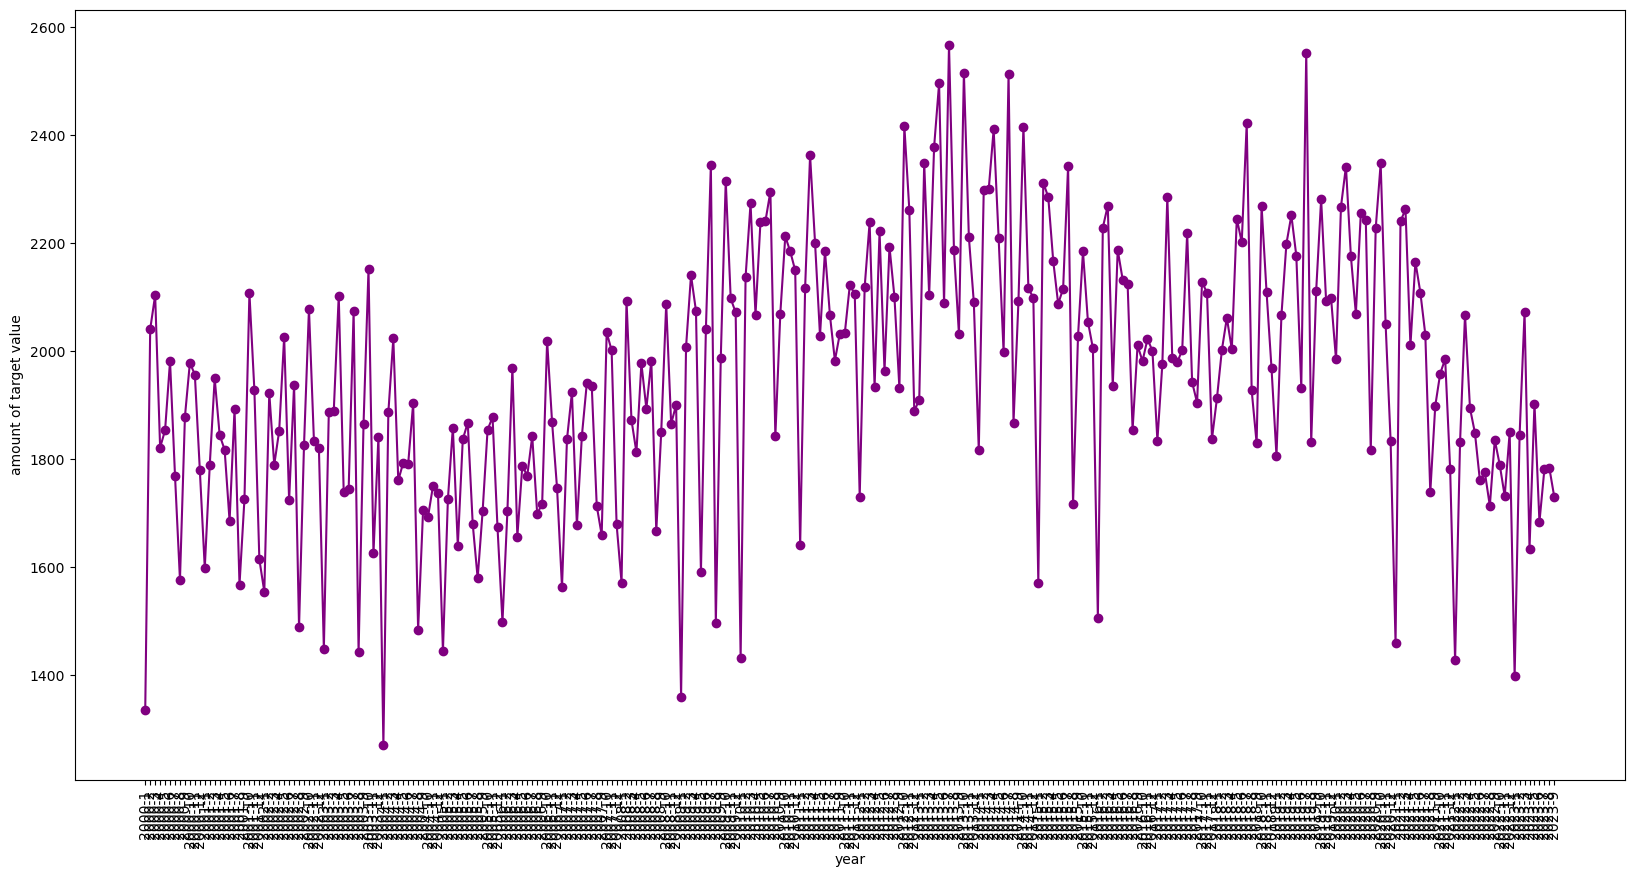

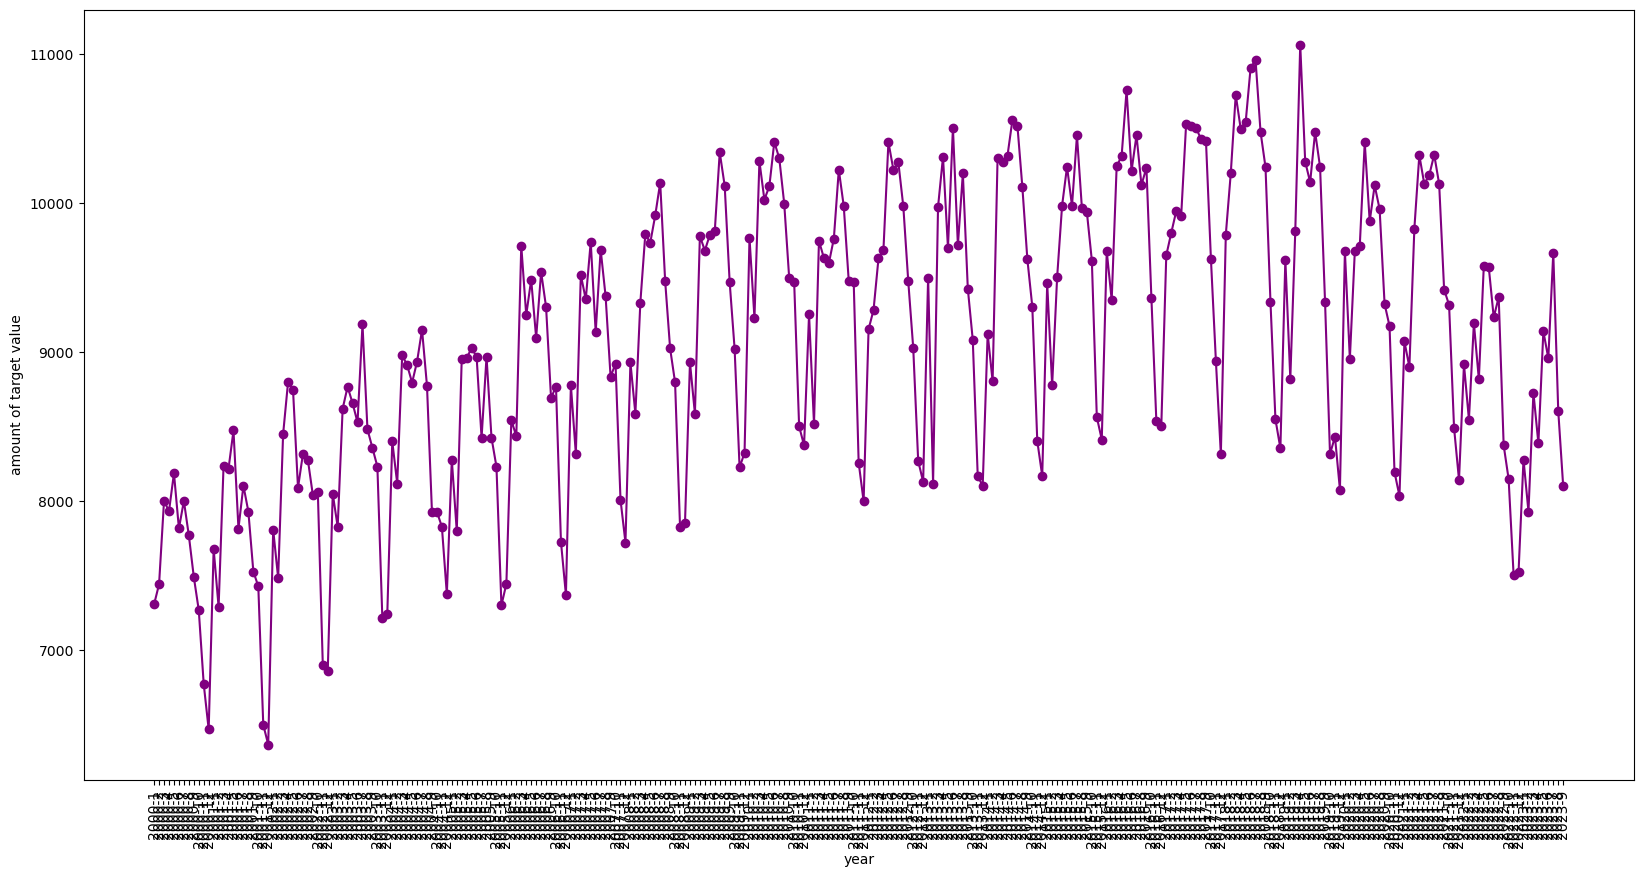

In [4]:
#visualising time series
targets = [data['marriages'], data['divorces'], data['births']]

for target in targets:
    fig = plt.figure(figsize=(20, 10))
    plt.scatter(data['date'], target, color = 'purple')
    plt.plot(data['date'], target, '-', color = 'purple')
    plt.xlabel('year')
    plt.ylabel('amount of target value')
    plt.xticks(rotation = 90)
    plt.show()

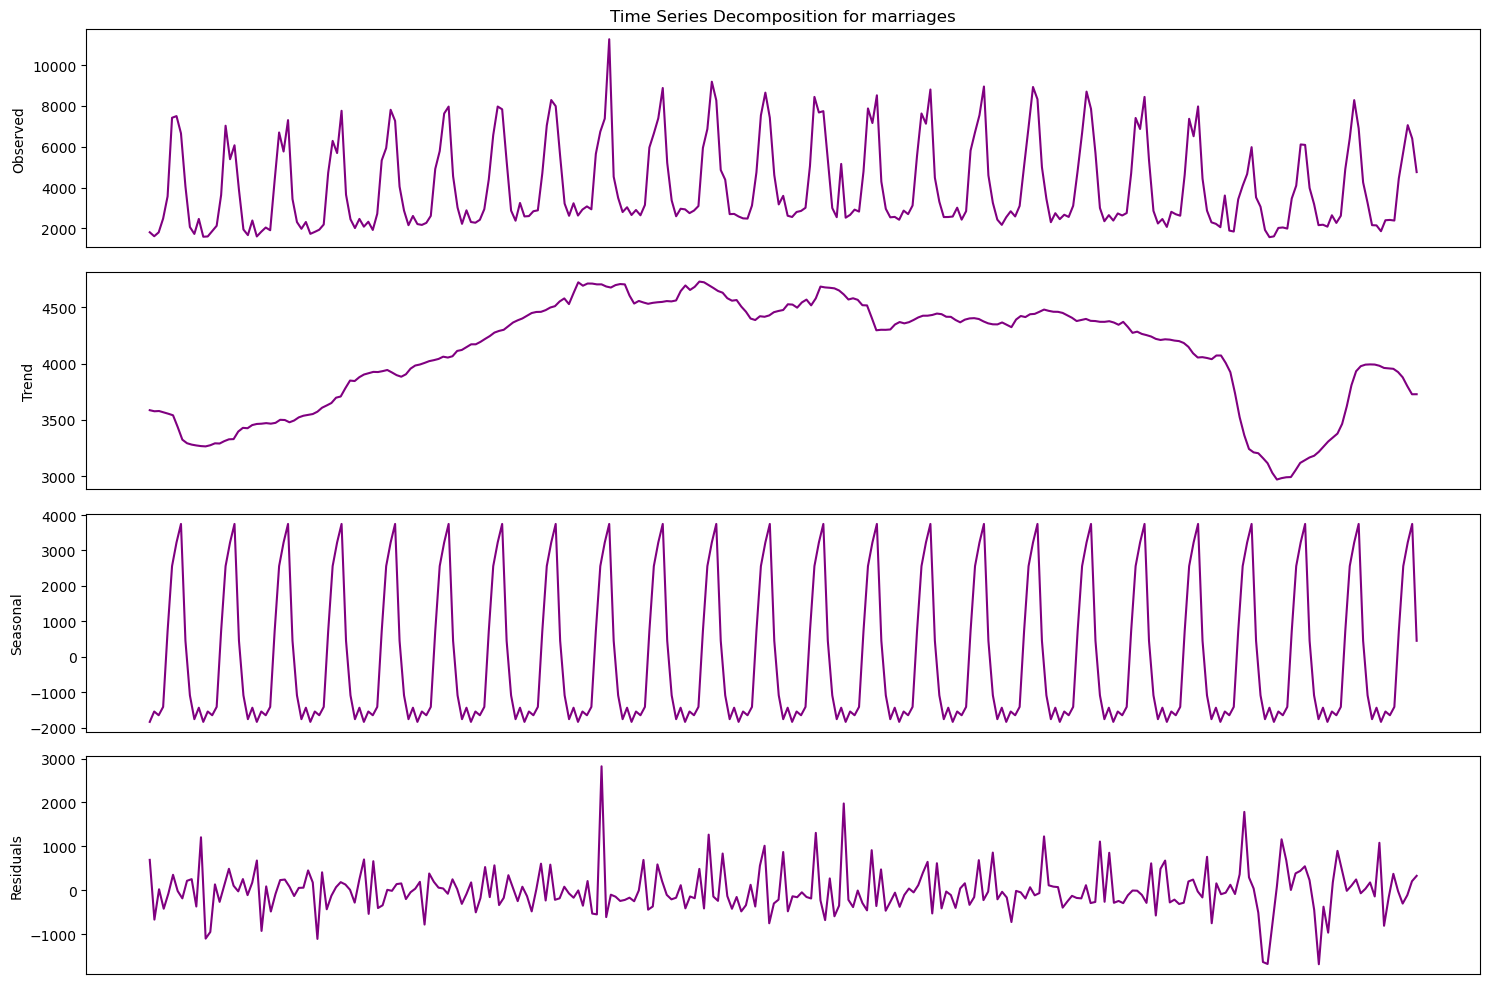

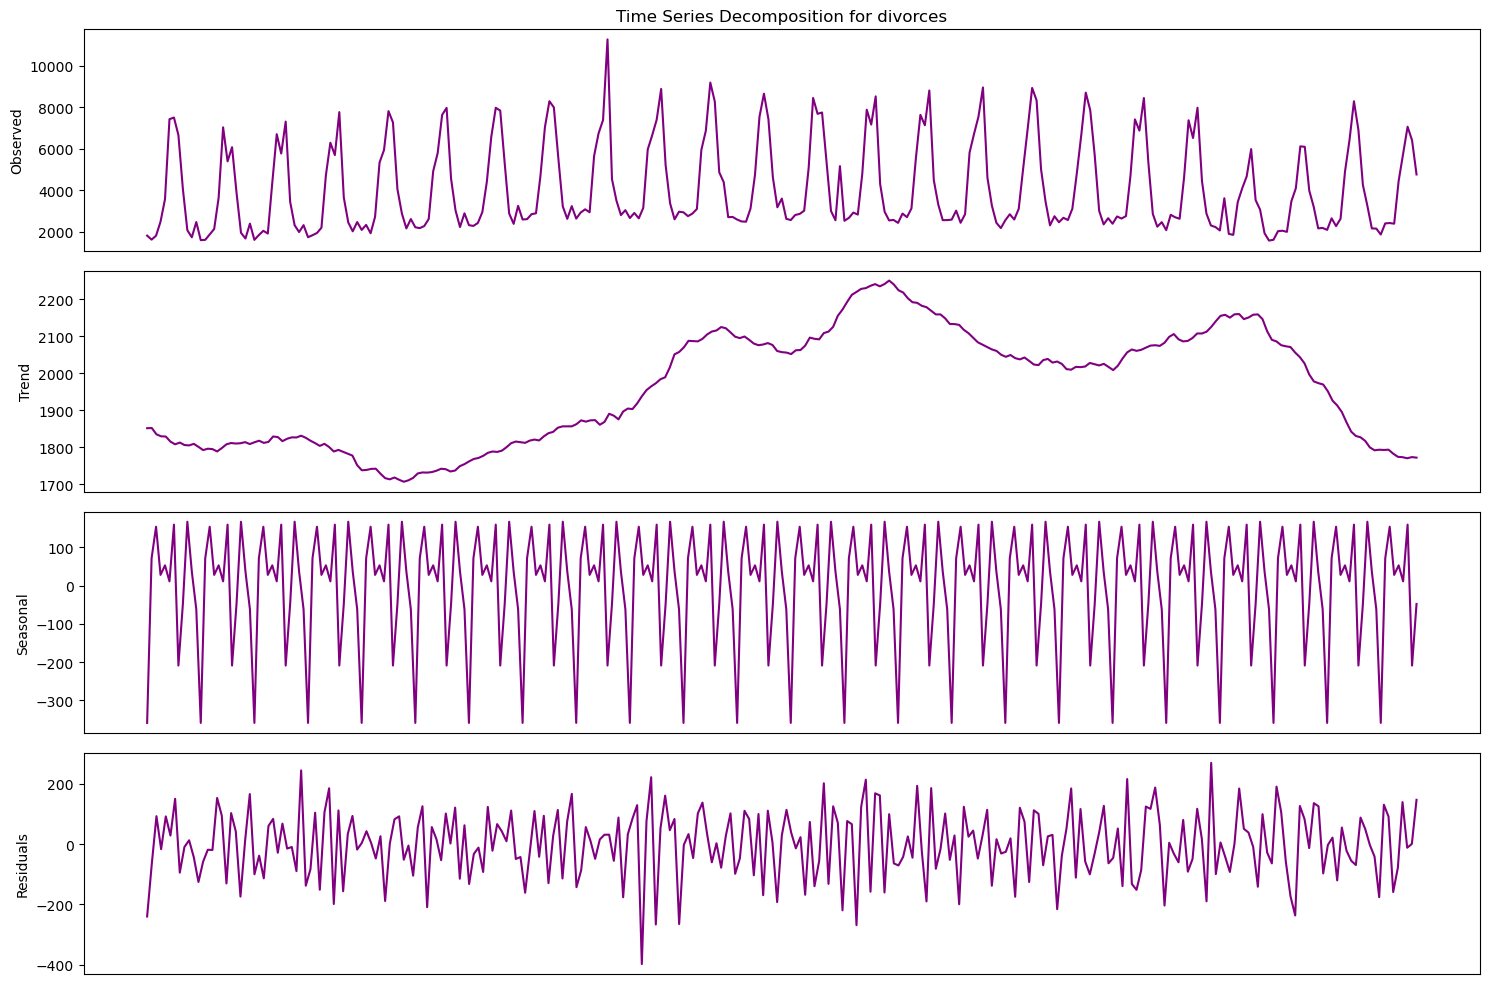

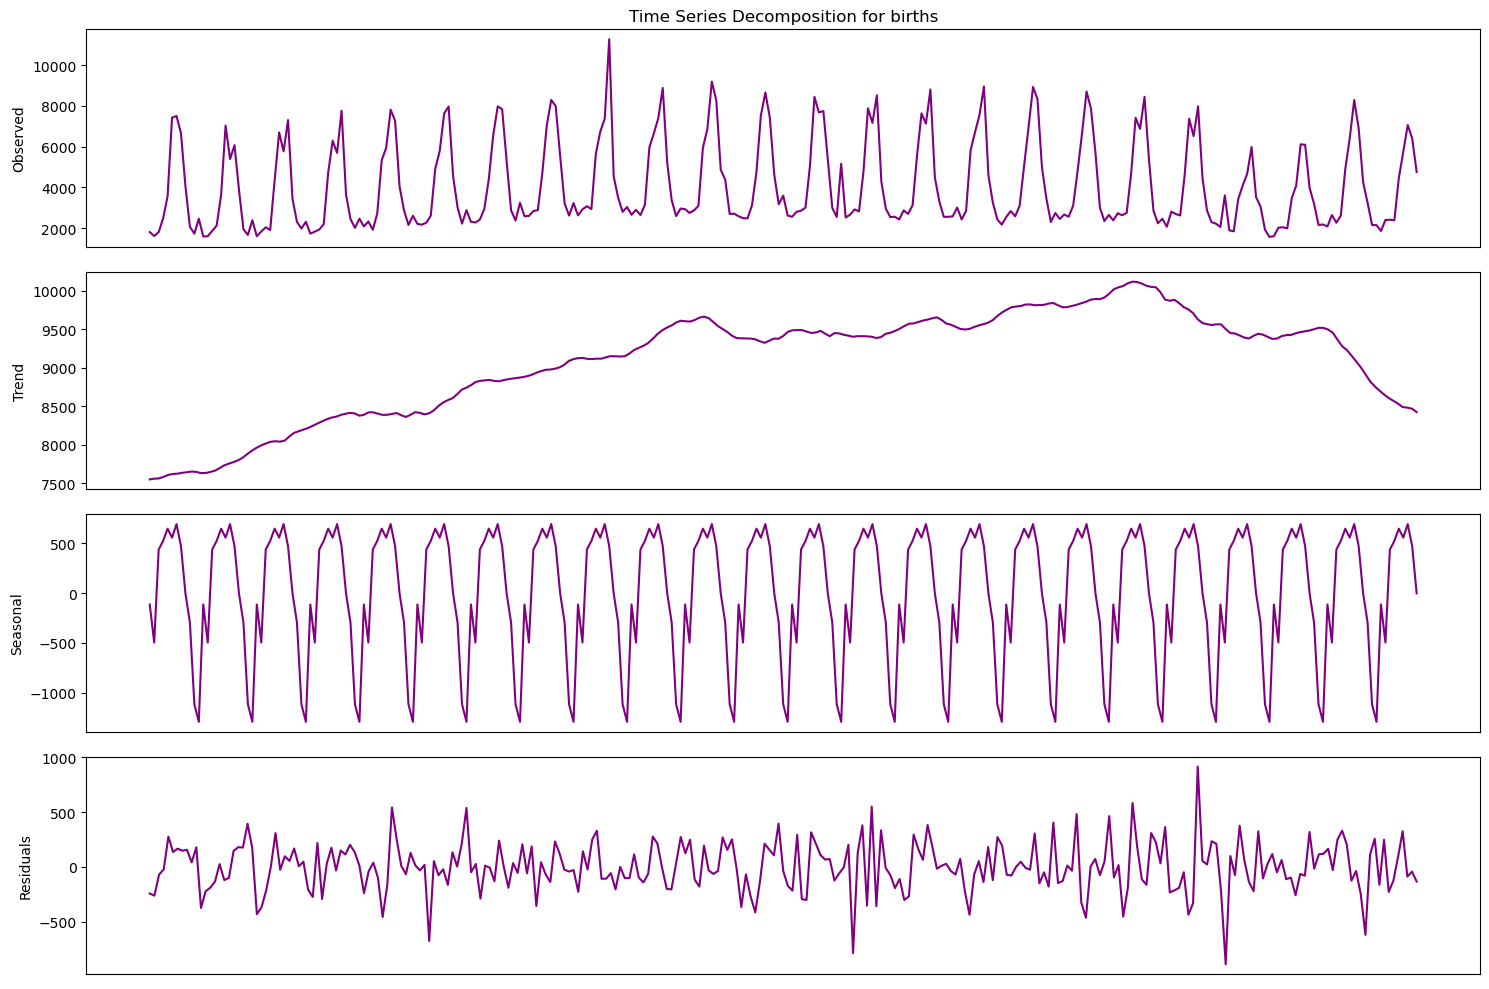

In [5]:
#Use time series decomposition to extract the trend and seasonal components
#for marriages
i = 0
for target in targets:
    period = 12  #specifying the period
    decomposition = seasonal_decompose(target, model='additive', period = period)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residuals = decomposition.resid
    
    plt.figure(figsize=(15,10))
    #Observed
    plt.subplot(411)
    plt.plot(data['marriages'], color = 'purple')
    plt.ylabel('Observed')
    if (i == 0):
        plt.title('Time Series Decomposition for marriages')
    elif (i == 1):
        plt.title('Time Series Decomposition for divorces')
    elif (i == 2):
        plt.title('Time Series Decomposition for births')
    plt.xticks([], [])

    #Trend
    plt.subplot(412)
    plt.plot(trend, color = 'purple')
    plt.ylabel('Trend')
    plt.xticks([], [])

    #Seasonal
    plt.subplot(413)
    plt.plot(seasonal, color = 'purple')
    plt.ylabel('Seasonal')
    plt.xticks([], [])
    
    #Residual 
    plt.subplot(414)
    plt.plot(residuals, color = 'purple')
    plt.ylabel('Residuals')
    plt.xticks([], [])

    plt.tight_layout()
    plt.show()
    i += 1

In [6]:
#Divide the data into train and test sets
train = data[:-9]
test = data[-9:]

##### 3) Fit a SARIMA model.

In [7]:
#using addfuller test for each of targets
for target in targets:
    ADF_result = adfuller(target)
    print(f'ADF Statistic: {ADF_result[0]}')
    print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.818692107870109
p-value: 0.37122186026898996
ADF Statistic: -1.5814479637622298
p-value: 0.49290575484453336
ADF Statistic: -1.922241864946368
p-value: 0.3216712550808651


In [8]:
#as we can see all of them are not stationary so we have to apply differencing
#marriages
data_diff = np.diff(data['marriages'], n=1)
ADF_result = adfuller(data_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value for marriages: {ADF_result[1]}')

#divorces
data_diff = np.diff(data['divorces'], n=1)
ADF_result = adfuller(data_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value for divorces: {ADF_result[1]}')

#births
data_diff = np.diff(data['births'], n=1)
ADF_result = adfuller(data_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value for births: {ADF_result[1]}')

ADF Statistic: -5.747575752834356
p-value for marriages: 6.071066094808128e-07
ADF Statistic: -3.2637818269531627
p-value for divorces: 0.016577116032380962
ADF Statistic: -3.7478475942370704
p-value for births: 0.00348831481883312


As we can see, all the p-values are less than 0.05 => stationary

In [9]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)
d = 1
D = 1
m = 12
SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train_1 = data['marriages'][:-12] 
train_2 = data['divorces'][:-12] 
train_3 = data['births'][:-12] 

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, m: int)-> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), 
                seasonal_order=(order[2], D, order[3], m),
                simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC',
    ascending=True).reset_index(drop=True)
    return result_df

In [69]:
#for marriages
SARIMA_result_df = optimize_SARIMA(train_1, SARIMA_order_list, d, D, m)
SARIMA_result_df

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/256 [00:00<?, ?it/s]

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

,"(p,q,P,Q)",AIC
0,"(0, 1, 2, 3)",4030.862915
1,"(0, 2, 2, 3)",4039.173231
2,"(3, 3, 1, 3)",4048.767007
3,"(3, 1, 3, 1)",4051.144838
4,"(3, 2, 3, 1)",4051.798028
...,...,...
251,"(0, 0, 0, 1)",4241.898703
252,"(0, 0, 3, 0)",4246.460778
253,"(0, 0, 2, 0)",4274.582877
254,"(0, 0, 1, 0)",4289.731663


In [97]:
#for divorces
SARIMA_result_df = optimize_SARIMA(train_2, SARIMA_order_list, d, D, m)
SARIMA_result_df

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/256 [00:00<?, ?it/s]

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimiza

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

,"(p,q,P,Q)",AIC
0,"(3, 1, 2, 3)",3243.229442
1,"(3, 2, 2, 3)",3250.563945
2,"(3, 3, 3, 3)",3255.535655
3,"(1, 2, 3, 3)",3256.187718
4,"(1, 2, 2, 3)",3256.277901
...,...,...
251,"(1, 0, 0, 0)",3505.639121
252,"(0, 0, 3, 0)",3511.424805
253,"(0, 0, 2, 0)",3551.394451
254,"(0, 0, 1, 0)",3564.007678


In [109]:
#for births
SARIMA_result_df = optimize_SARIMA(train_3, SARIMA_order_list, d, D, m)
SARIMA_result_df

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/256 [00:00<?, ?it/s]

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

,"(p,q,P,Q)",AIC
0,"(1, 2, 2, 3)",359.824043
1,"(0, 1, 0, 1)",3702.186716
2,"(3, 2, 0, 1)",3703.324811
3,"(2, 2, 1, 1)",3703.529005
4,"(0, 2, 0, 1)",3703.564782
...,...,...
250,"(0, 0, 2, 0)",3840.288478
251,"(2, 0, 0, 0)",3843.507555
252,"(0, 0, 1, 0)",3862.256516
253,"(1, 0, 0, 0)",3875.291689


as we can see, the optimized model for forecasting
    marriages - SARIMA(0, 1, 1)(2, 1, 3)
    divorces - SARIMA(3, 1, 1)(2, 1, 3)
    births - SARIMA(1, 1, 2)(2, 1, 3)

##### FITTING SARIMA MODEL AND FORECASTING

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


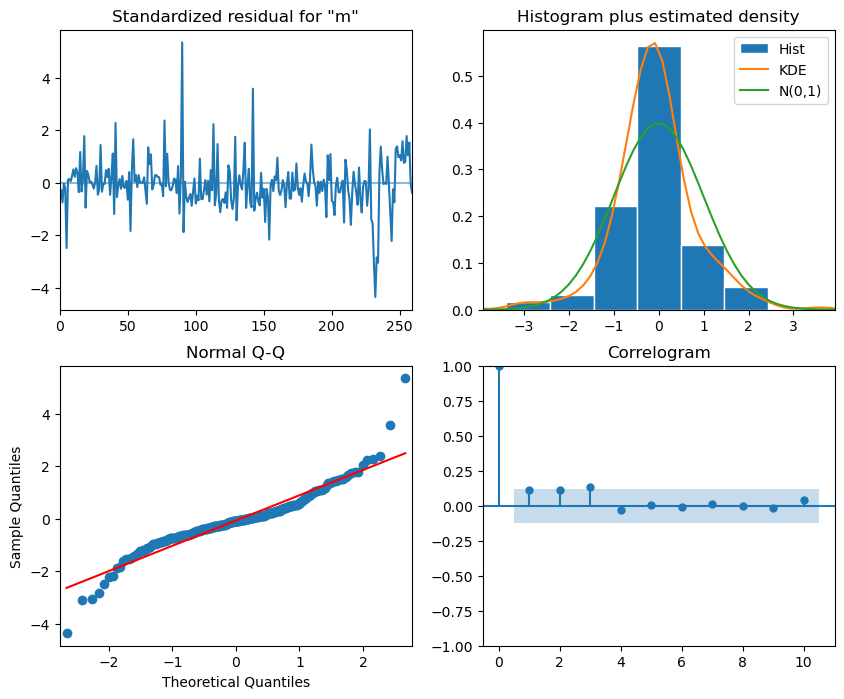

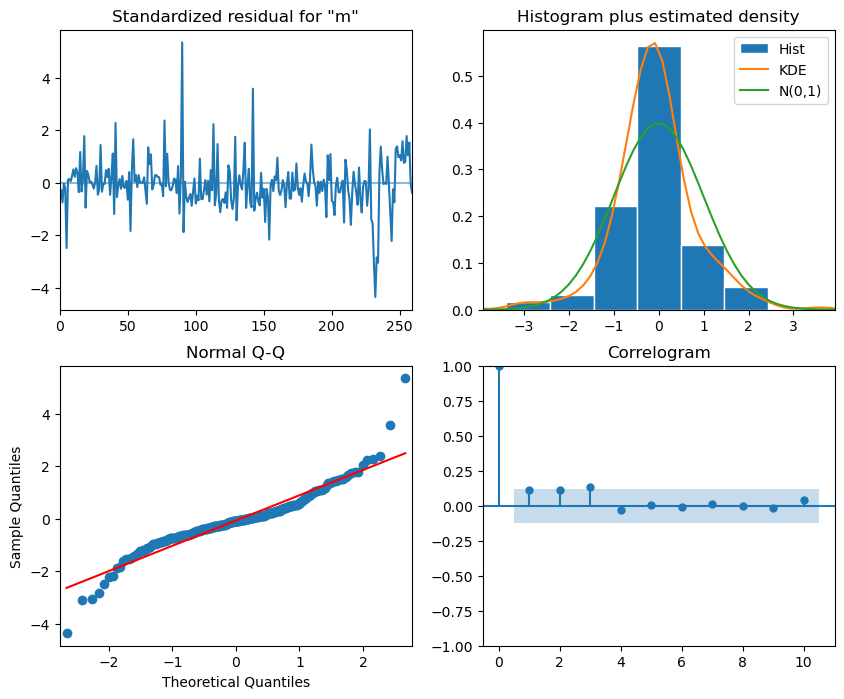

In [20]:
#MARRIAGES
data_tmp = pd.DataFrame(data['marriages'])

SARIMA_model_mar = SARIMAX(train_1, order=(0, 1, 2), seasonal_order=(2, 1, 3, 12), simple_differencing=False)
SARIMA_model_fit_mar = SARIMA_model_mar.fit(disp=False)
SARIMA_model_fit_mar.plot_diagnostics(figsize=(10,8))

chosen baseline models: historical mean and last known value

In [21]:
#predicting values using SARIMA - MARRIAGES
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    if method == 'mean':
        pred_mean = [] 
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    elif method == 'SARIMA':
        pred_SARIMA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(train_1, order=(0, 1, 2), seasonal_order=(2, 1, 3, 12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(pred)
        return pred_SARIMA

In [22]:
pred_df = test.copy()
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 3

pred_mean = rolling_forecast(data_tmp, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(data_tmp, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMA = rolling_forecast(data_tmp, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

pred_df.loc[:, 'pred_mean'] = pred_mean
pred_df.loc[:, 'pred_last_value'] = pred_last_value
pred_df.loc[:, 'pred_SARIMA'] = pred_SARIMA

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


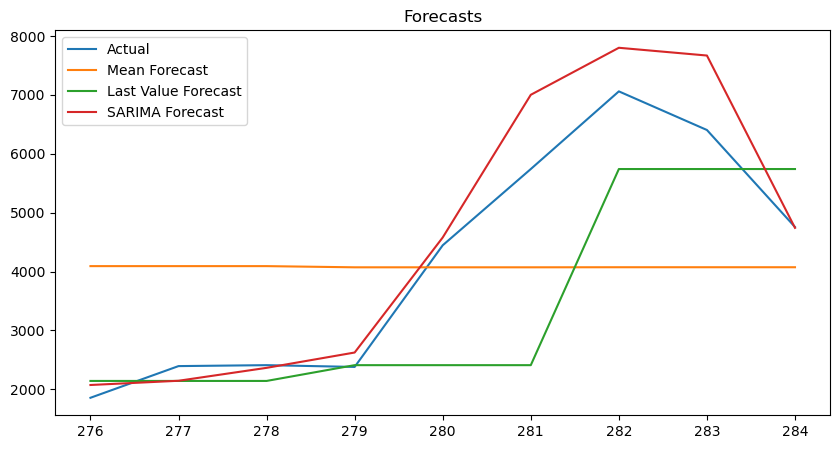

In [23]:
#Plotting all the forecasts
plt.figure(figsize=(10, 5))
plt.plot(pred_df.index, test['marriages'].values, label='Actual')
plt.plot(pred_df.index, pred_mean, label='Mean Forecast')
plt.plot(pred_df.index, pred_last_value, label='Last Value Forecast')
plt.plot(pred_df.index, pred_SARIMA, label='SARIMA Forecast')
plt.title('Forecasts')
plt.legend()
plt.show()

In [24]:
mape_mean = mape(test['marriages'], pred_mean)
mape_last = mape(test['marriages'], pred_last_value)
mape_SARIMA = mape(test['marriages'], pred_SARIMA) 

print("Historical mean error marriages: ", mape_mean) 
print("Last known value error marriages: ", mape_last) 
print("SARIMA error marriages: ", mape_SARIMA) 

Historical mean error marriages:  0.5142548058647172
Last known value error marriages:  0.2131979585435049
SARIMA error marriages:  0.09972732838098824


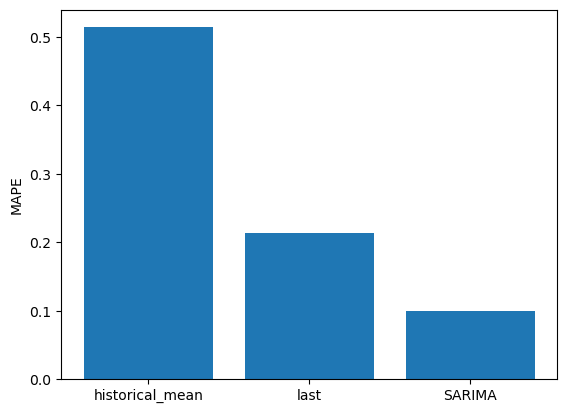

In [25]:
#barplots to show difference between mape
fig, ax = plt.subplots()
bars = ['historical_mean', 'last', 'SARIMA']
counts = [mape_mean, mape_last, mape_SARIMA]

ax.bar(bars, counts)
ax.set_ylabel('MAPE')
plt.show()

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


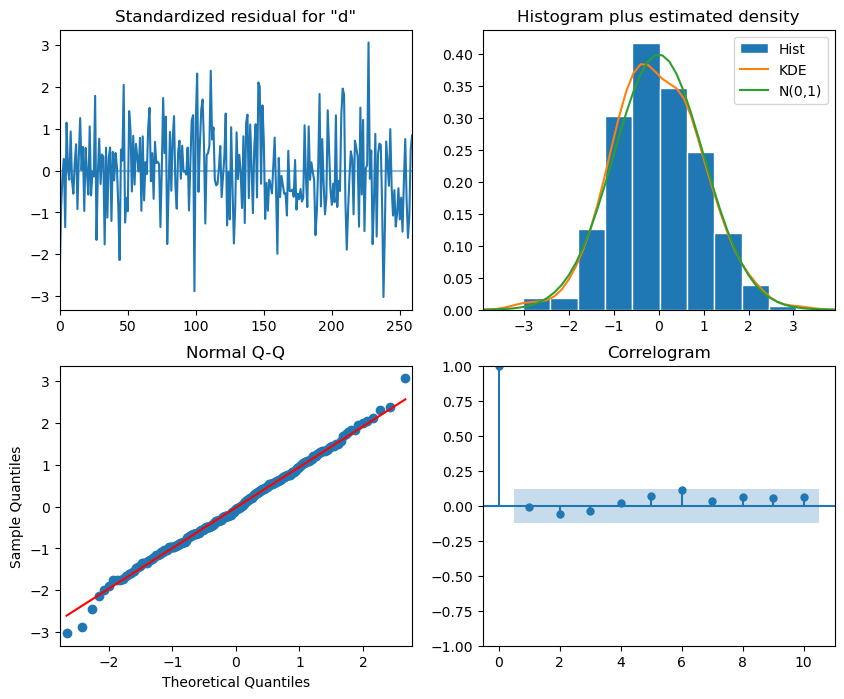

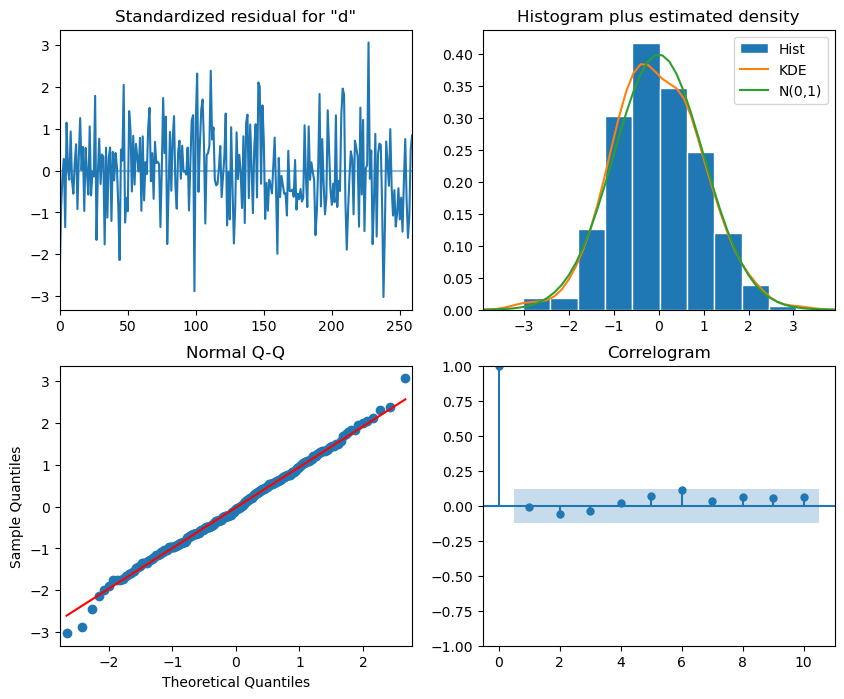

In [26]:
#DIVORCES
data_tmp = pd.DataFrame(data['divorces'])

SARIMA_model_div = SARIMAX(train_2, order=(3, 1, 1), seasonal_order=(2, 1, 3, 12), simple_differencing=False)
SARIMA_model_fit_div = SARIMA_model_div.fit(disp=False)
SARIMA_model_fit_div.plot_diagnostics(figsize=(10,8))

In [27]:
#predicting values using SARIMA - DIVORCES
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    if method == 'mean':
        pred_mean = [] 
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    elif method == 'SARIMA':
        pred_SARIMA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(train_2, order=(3, 1, 1), seasonal_order=(2, 1, 3, 12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(pred)
        return pred_SARIMA

In [28]:
pred_df = test.copy()
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 3

pred_mean = rolling_forecast(data_tmp, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(data_tmp, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMA = rolling_forecast(data_tmp, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

pred_df.loc[:, 'pred_mean'] = pred_mean
pred_df.loc[:, 'pred_last_value'] = pred_last_value
pred_df.loc[:, 'pred_SARIMA'] = pred_SARIMA

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


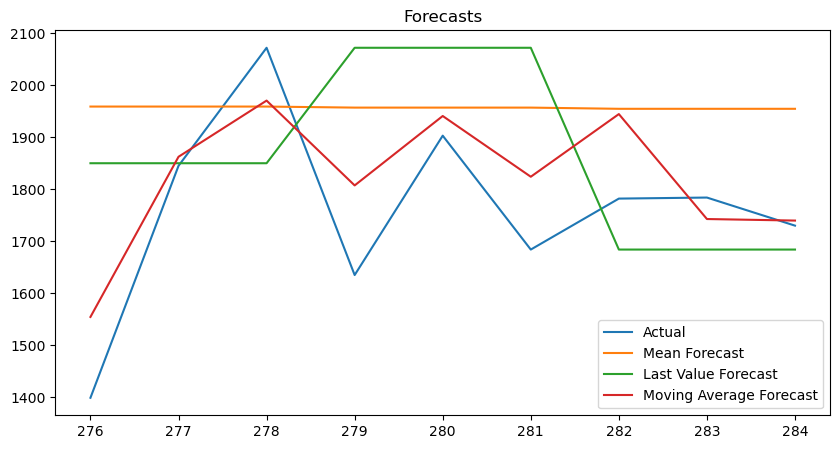

In [19]:
#Plotting all the forecasts
plt.figure(figsize=(10, 5))
plt.plot(pred_df.index, test['divorces'].values, label='Actual')
plt.plot(pred_df.index, pred_mean, label='Mean Forecast')
plt.plot(pred_df.index, pred_last_value, label='Last Value Forecast')
plt.plot(pred_df.index, pred_SARIMA, label='SARIMA Forecast')
plt.title('Forecasts')
plt.legend()
plt.show()

In [29]:
mape_mean = mape(test['divorces'], pred_mean)
mape_last = mape(test['divorces'], pred_last_value)
mape_SARIMA = mape(test['divorces'], pred_SARIMA) 

print("Historical mean error divorces: ", mape_mean) 
print("Last known value error divorces: ", mape_last) 
print("SARIMA error divorces: ", mape_SARIMA) 

Historical mean error divorces:  0.13626119668742034
Last known value error divorces:  0.12848367086810777
SARIMA error divorces:  0.055326303878105186


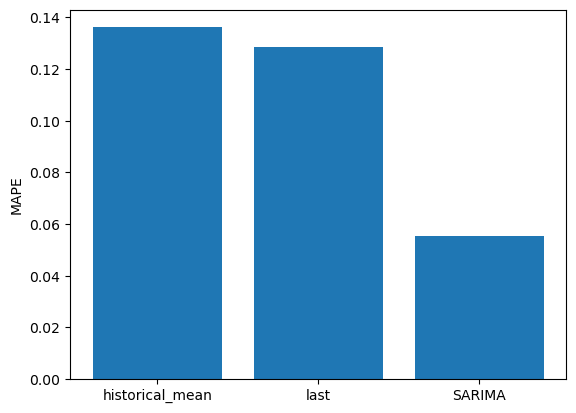

In [30]:
#barplots to show difference between mape
fig, ax = plt.subplots()
bars = ['historical_mean', 'last', 'SARIMA']
counts = [mape_mean, mape_last, mape_SARIMA]
ax.bar(bars, counts)
ax.set_ylabel('MAPE')
plt.show()

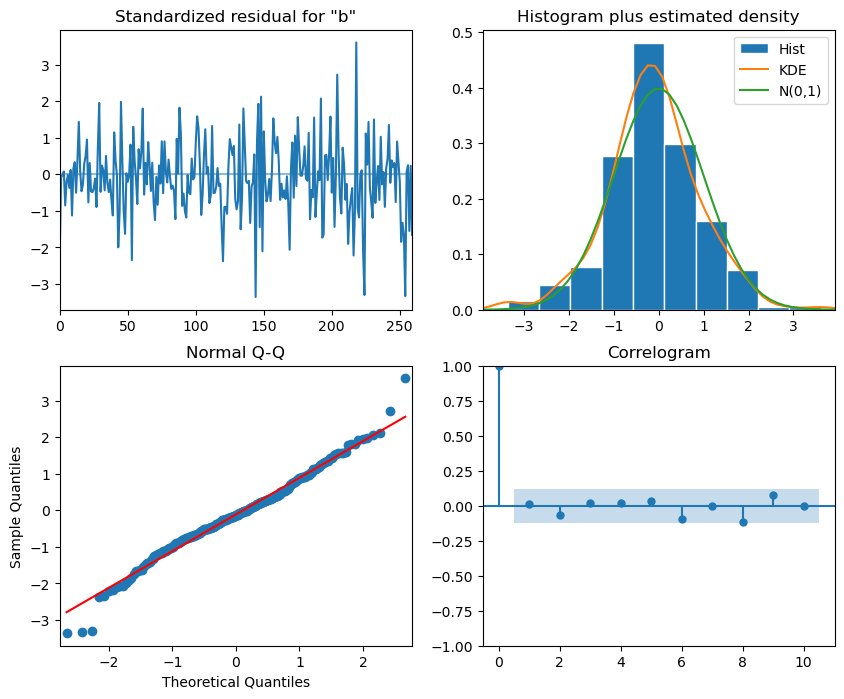

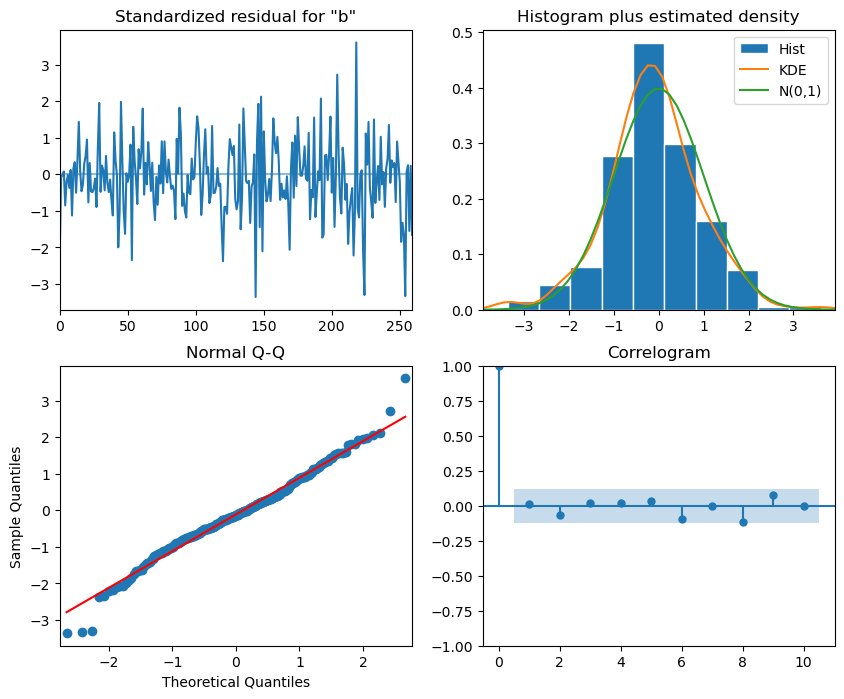

In [31]:
#BIRTHS
SARIMA_model_bir = SARIMAX(train_3, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12), simple_differencing=False)
SARIMA_model_fit_bir = SARIMA_model_bir.fit(disp=False)
SARIMA_model_fit_bir.plot_diagnostics(figsize=(10,8))

In [32]:
#predicting values using SARIMA - BIRTHS
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    if method == 'mean':
        pred_mean = [] 
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    elif method == 'SARIMA':
        pred_SARIMA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(train_3, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(pred)
        return pred_SARIMA

In [33]:
pred_df = test.copy()
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 3

pred_mean = rolling_forecast(data_tmp, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(data_tmp, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMA = rolling_forecast(data_tmp, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

pred_df.loc[:, 'pred_mean'] = pred_mean
pred_df.loc[:, 'pred_last_value'] = pred_last_value
pred_df.loc[:, 'pred_SARIMA'] = pred_SARIMA

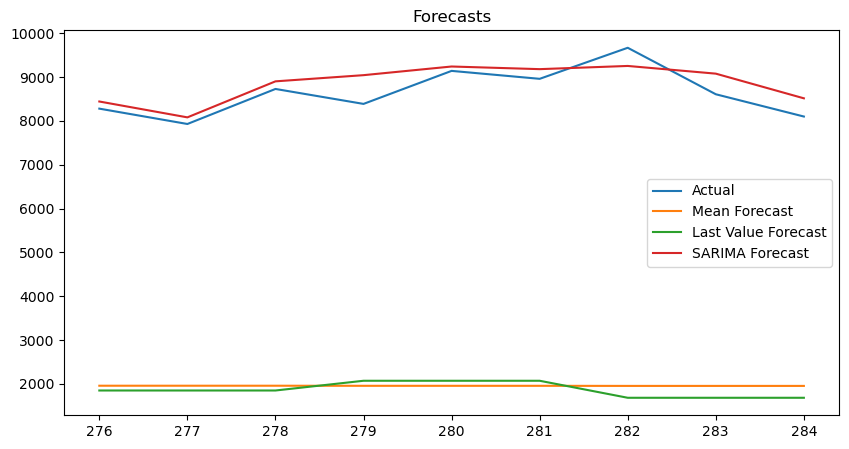

In [34]:
#Plotting all the forecasts
plt.figure(figsize=(10, 5))
plt.plot(pred_df.index, test['births'].values, label='Actual')
plt.plot(pred_df.index, pred_mean, label='Mean Forecast')
plt.plot(pred_df.index, pred_last_value, label='Last Value Forecast')
plt.plot(pred_df.index, pred_SARIMA, label='SARIMA Forecast')
plt.title('Forecasts')
plt.legend()
plt.show()

In [35]:
mape_mean = mape(test['births'], pred_mean)
mape_last = mape(test['births'], pred_last_value)
mape_SARIMA = mape(test['births'], pred_SARIMA) 

print("Historical mean error births: ", mape_mean) 
print("Last known value error births: ", mape_last) 
print("SARIMA error births: ", mape_SARIMA) 

Historical mean error births:  0.7727902324543877
Last known value error births:  0.783136717278698
SARIMA error births:  0.03567543615108797


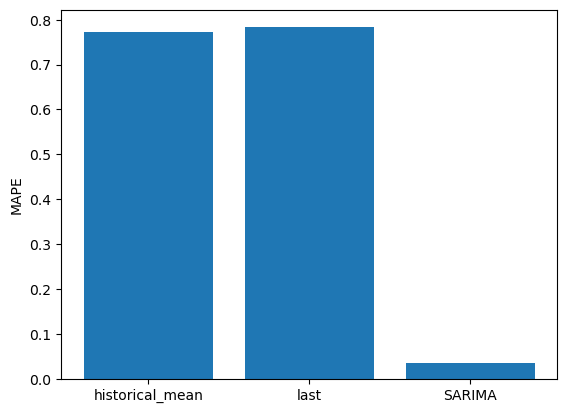

In [36]:
#barplots to show difference between mape
fig, ax = plt.subplots()
bars = ['historical_mean', 'last', 'SARIMA']
counts = [mape_mean, mape_last, mape_SARIMA]
ax.bar(bars, counts)
ax.set_ylabel('MAPE')
plt.show()

##### As it is seen from the results of applying different models, SARIMA gives significantly better results than baseline models for all of the targets

#### 4) Could you think of external variables that have impact on any of the three series? Fit a SARIMAX model.

External variables that have, as i think, the most serious impact on pretty much all of the series because all three factors may depend on them:

    - GDP
    - unemployment rate
    - inflation rate
Also maybe some demographic variables that are related to the population structure, such as:

    - age distribution
    - educational attainment 
    - migration rates

In this task I'll use gdp as external variable.
file 'gdp.csv' contains gdp for each year from 2000 til 2022

#### FIT A SARIMAX MODEL

In [9]:
#getting the external variable information
gdp_data = pd.read_csv('gdp.csv')
mean_values = gdp_data.mean()
extra_rows = len(data) - len(gdp_data)
new_rows = pd.DataFrame([mean_values] * extra_rows)
expanded_gdp = pd.concat([gdp_data, new_rows], ignore_index=True)
gdp = pd.DataFrame(expanded_gdp['gdp'])

In [10]:
gdp_train = pd.DataFrame(gdp[:-9])
gdp_test = pd.DataFrame(gdp[-9:])

In [11]:
#checking stationarity
ad_fuller_result = adfuller(gdp)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.7719020143436555
p-value: 0.003208237722692371


p-value is less than 0.05 -> stationary -> d = 0

In [12]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)
d = 0
D = 0
m = 12
parameters_list = list(product(ps, qs, Ps, Qs)) 

def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list],
                     order_list: list, d: int, D: int, m: int) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list):
            try:
                model = SARIMAX(endog, exog, order=(order[0], d, order[1]),
                            seasonal_order=(order[2], D, order[3], m),
                            simple_differencing=False).fit(disp=False)
            except:
                continue
            aic = model.aic
            results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

#### MARRIAGES

In [13]:
result_df = optimize_SARIMAX(train['marriages'], gdp_train, parameters_list, d, D, m)

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/256 [00:00<?, ?it/s]

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

In [14]:
result_df

,"(p,q,P,Q)",AIC
0,"(0, 0, 3, 1)",12.000000
1,"(3, 0, 1, 2)",4348.101976
2,"(0, 3, 1, 3)",4357.028044
3,"(3, 0, 1, 3)",4369.352808
4,"(2, 0, 2, 1)",4376.926619
...,...,...
239,"(0, 0, 0, 2)",4848.153168
240,"(0, 2, 0, 0)",4855.126384
241,"(0, 0, 0, 1)",4924.794633
242,"(0, 1, 0, 0)",4926.536567


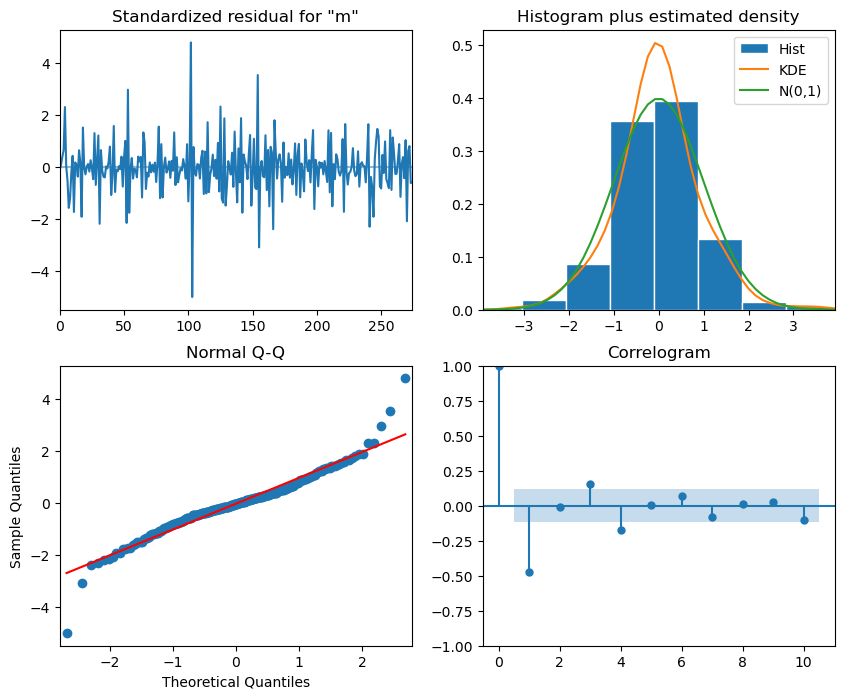

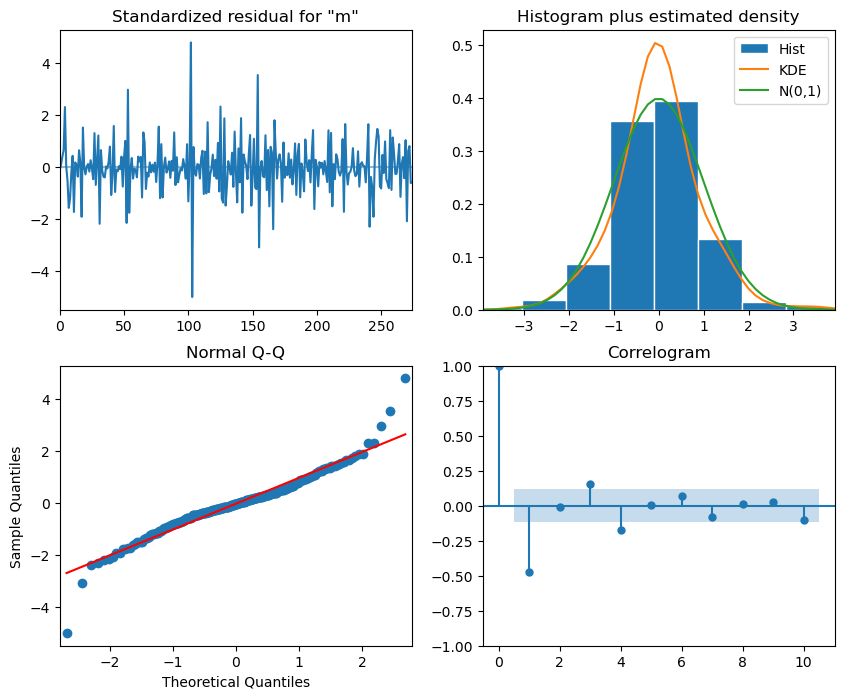

In [16]:
data_tmp = data['marriages']

best_model = SARIMAX(train['marriages'], gdp_train, order=(0, 1, 0), seasonal_order=(3, 0, 1, 12), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)
best_model_fit.plot_diagnostics(figsize=(10,8))

In [17]:
def rolling_forecast_sarimax(df, exog, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon

    if method == 'SARIMAX':
        pred_SARIMAX = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], exog[:i], order=(0, 1, 0), seasonal_order=(3, 0, 1, 12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
        return pred_SARIMAX[:horizon]

In [18]:
pred_df = test.copy()
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_SARIMAX = rolling_forecast_sarimax(data_tmp, gdp, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')
pred_df.loc[:, 'pred_SARIMAX'] = pred_SARIMAX

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

In [20]:
mape_SARIMAX = mape(test['marriages'], pred_SARIMAX) 
print("SARIMAX error marriages: ", mape_SARIMAX) 

SARIMAX error marriages:  0.21444447380351703


#### DIVORCES

In [21]:
result_df = optimize_SARIMAX(train['divorces'], gdp_train, parameters_list, d, D, m)
result_df

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/256 [00:00<?, ?it/s]

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

,"(p,q,P,Q)",AIC
0,"(2, 2, 0, 0)",12.000000
1,"(1, 0, 1, 2)",12.000000
2,"(0, 1, 2, 1)",12.000000
3,"(2, 3, 0, 0)",14.000000
4,"(0, 3, 2, 1)",16.000000
...,...,...
222,"(0, 1, 0, 0)",4191.405611
223,"(0, 0, 0, 3)",4205.771505
224,"(0, 0, 0, 2)",4296.981632
225,"(0, 0, 0, 1)",4336.788666


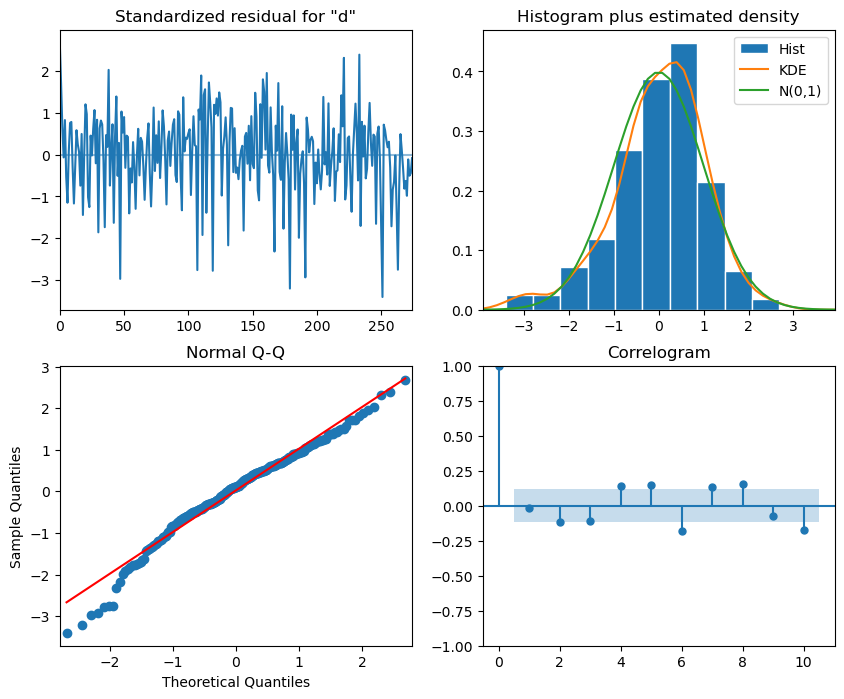

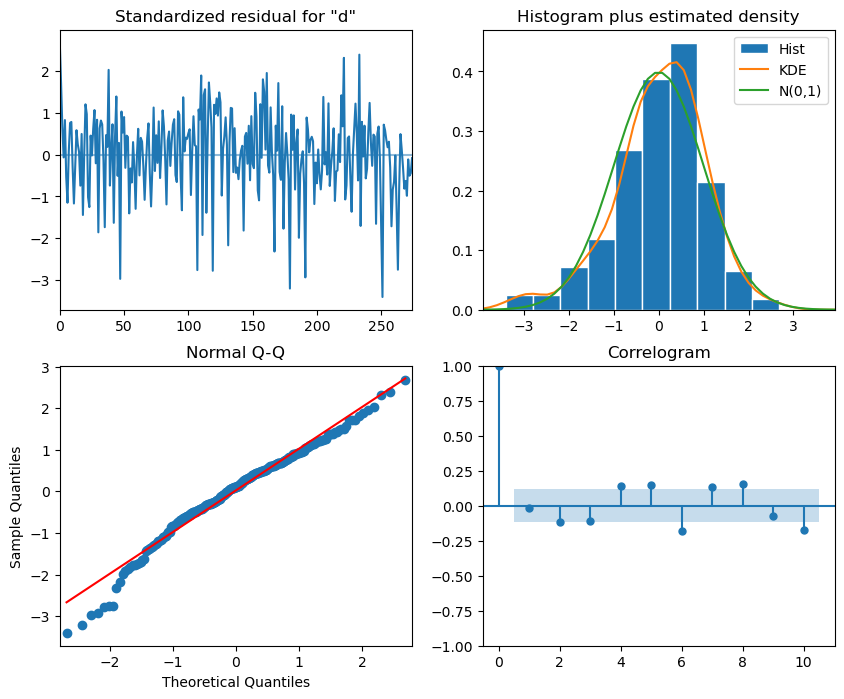

In [22]:
data_tmp = data['divorces']

best_model = SARIMAX(train['divorces'], gdp_train, order=(2, 1, 2), seasonal_order=(0, 0, 0, 12), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)
best_model_fit.plot_diagnostics(figsize=(10,8))

In [23]:
def rolling_forecast_sarimax(df, exog, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon

    if method == 'SARIMAX':
        pred_SARIMAX = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(train['divorces'], gdp_train, order=(2, 1, 2), seasonal_order=(0, 0, 0, 12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
        return pred_SARIMAX[:horizon]

In [24]:
pred_df = test.copy()
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_SARIMAX = rolling_forecast_sarimax(data_tmp, gdp, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')
pred_df.loc[:, 'pred_SARIMAX'] = pred_SARIMAX

In [26]:
mape_SARIMAX = mape(test['divorces'], pred_SARIMAX) 
print("SARIMAX error divorces: ", mape_SARIMAX) 

SARIMAX error divorces:  0.09833105545292974


#### BIRTHS

In [27]:
result_df = optimize_SARIMAX(train['births'], gdp_train, parameters_list, d, D, m)
result_df

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/256 [00:00<?, ?it/s]

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

,"(p,q,P,Q)",AIC
0,"(2, 0, 1, 0)",10.000000
1,"(0, 1, 2, 0)",10.000000
2,"(0, 1, 2, 1)",12.000000
3,"(2, 2, 0, 0)",12.000000
4,"(0, 1, 2, 3)",16.000000
...,...,...
207,"(0, 1, 3, 3)",4959.472494
208,"(0, 0, 0, 3)",5000.155159
209,"(0, 0, 0, 2)",5109.932484
210,"(0, 0, 0, 1)",5147.704151


C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


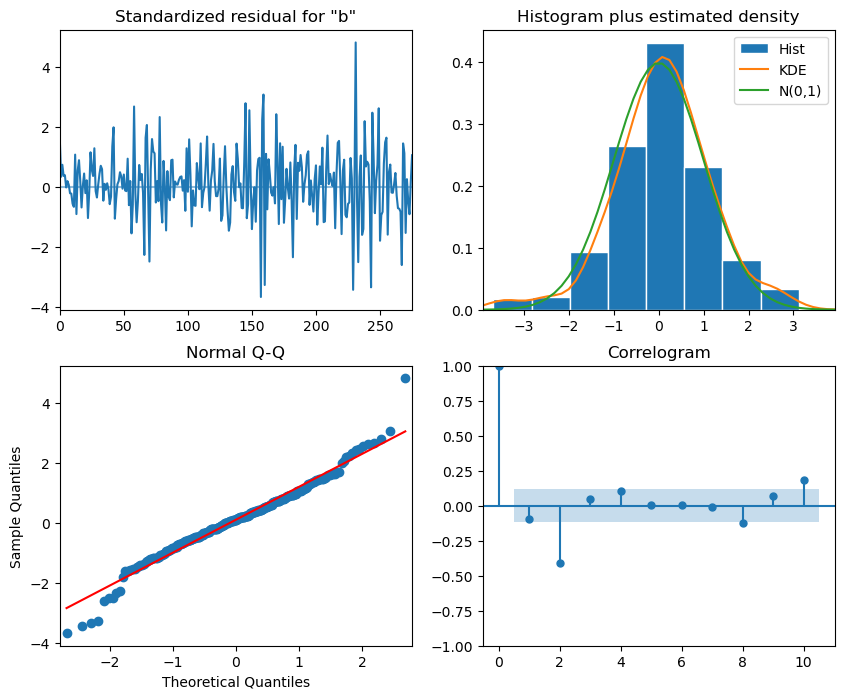

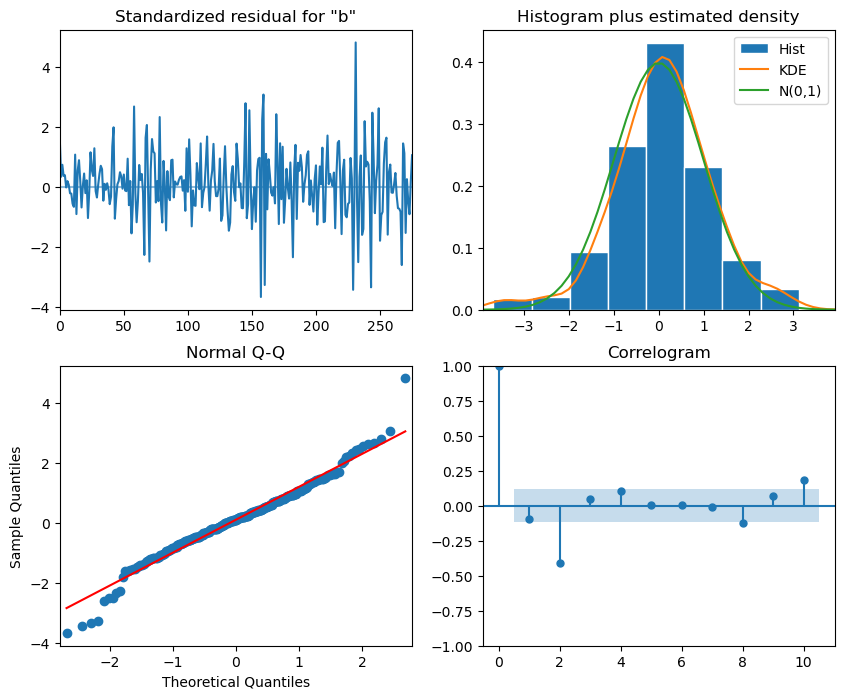

In [29]:
data_tmp = data['births']

best_model = SARIMAX(train['births'], gdp_train, order=(2, 0, 1), seasonal_order=(1, 0, 0, 12), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)
best_model_fit.plot_diagnostics(figsize=(10,8))

In [30]:
def rolling_forecast_sarimax(df, exog, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon

    if method == 'SARIMAX':
        pred_SARIMAX = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(train['births'], gdp_train, order=(2, 0, 1), seasonal_order=(1, 0, 0, 12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
        return pred_SARIMAX[:horizon]

In [31]:
pred_df = test.copy()
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_SARIMAX = rolling_forecast_sarimax(data_tmp, gdp, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')
pred_df.loc[:, 'pred_SARIMAX'] = pred_SARIMAX

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Convergenc

In [34]:
mape_SARIMAX = mape(test['births'], pred_SARIMAX) 
print("SARIMAX error births: ", mape_SARIMAX) 

SARIMAX error births:  0.17066578873645086


5) Is there inter-dependance between any of these three time series? If not, try to find another time series that is inter-dependant with the number of births, for example. Fit a VARMAX model.

I guess marriages and divorces may be interdependent and marriages and births

In [120]:
marriages_diff = np.diff(data['marriages'], n=1)
divorces_diff = np.diff(data['divorces'], n=1)
births_diff = np.diff(data['births'], n=1)

In [134]:
from statsmodels.tsa.statespace.varmax import VARMAX
def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame: 
    results = []
    for i in tqdm_notebook(range(15)): 
        try:
            model = VARMAX(endog, order=(i,0)).fit(dips=False)
        except:
            continue
        aic = model.aic
        results.append([i, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [135]:
data_diff = pd.DataFrame({'marriages':marriages_diff, 'divorces':divorces_diff, 'births': births_diff})
for col in data_diff.columns:
    data_diff[col] = data_diff[col].astype('float64')

train_diff = data_diff[:-9]
test_diff = data_diff[-9:]

In [136]:
result_df = optimize_VAR(train_diff)
result_df

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/15 [00:00<?, ?it/s]

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: dips. After release 0.14, this will raise.
  FutureWarning
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

,p,AIC
0,14,11718.585576
1,11,11743.025939
2,12,11748.435320
3,10,11842.956635
4,9,11896.159406
5,8,11970.854248
6,7,12043.760396
7,6,12072.921299
8,5,12143.228466
9,4,12324.215872


In [137]:
from statsmodels.tsa.stattools import grangercausalitytests
print('marriages Granger-causes divorces?\n')
granger_1 = grangercausalitytests(data_diff[['marriages','divorces']].diff()[1:], [14])
print('\divorces Granger-causes marriages?\n')
granger_2 = grangercausalitytests(data_diff[['divorces','marriages']].diff()[1:], [14]) 

print('marriages Granger-causes divorces?\n')
granger_3 = grangercausalitytests(data_diff[['marriages','births']].diff()[1:], [14])
print('\divorces Granger-causes marriages?\n')
granger_4 = grangercausalitytests(data_diff[['births','marriages']].diff()[1:], [14]) 

marriages Granger-causes divorces?


Granger Causality
number of lags (no zero) 14
ssr based F test:         F=3.6400  , p=0.0000  , df_denom=240, df_num=14
ssr based chi2 test:   chi2=57.1174 , p=0.0000  , df=14
likelihood ratio test: chi2=51.7949 , p=0.0000  , df=14
parameter F test:         F=3.6400  , p=0.0000  , df_denom=240, df_num=14
\divorces Granger-causes marriages?


Granger Causality
number of lags (no zero) 14
ssr based F test:         F=6.0403  , p=0.0000  , df_denom=240, df_num=14
ssr based chi2 test:   chi2=94.7824 , p=0.0000  , df=14
likelihood ratio test: chi2=81.1962 , p=0.0000  , df=14
parameter F test:         F=6.0403  , p=0.0000  , df_denom=240, df_num=14
marriages Granger-causes divorces?


Granger Causality
number of lags (no zero) 14
ssr based F test:         F=2.9673  , p=0.0003  , df_denom=240, df_num=14
ssr based chi2 test:   chi2=46.5616 , p=0.0000  , df=14
likelihood ratio test: chi2=42.9439 , p=0.0001  , df=14
parameter F test:         F=2.9673  , p=0.00

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


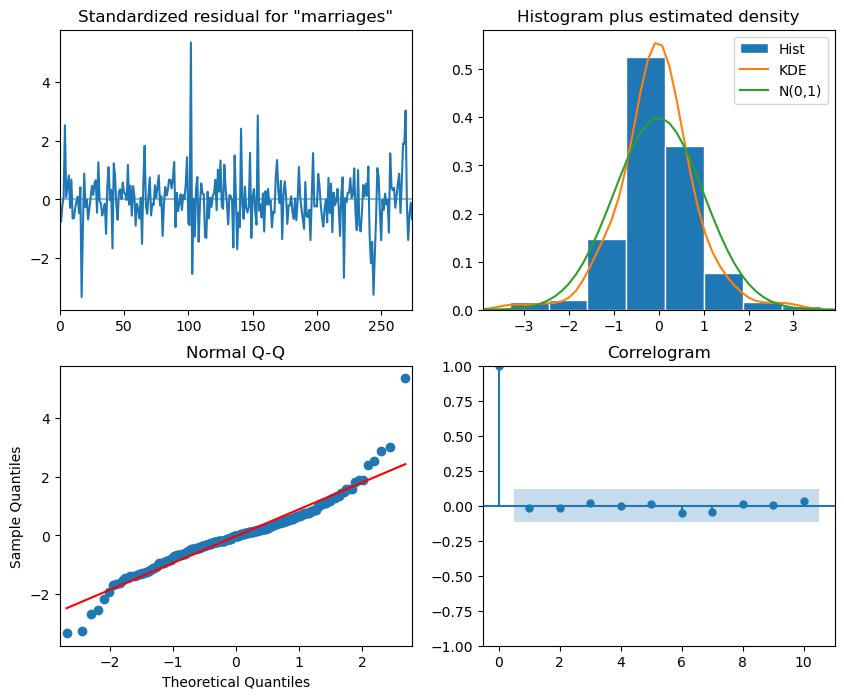

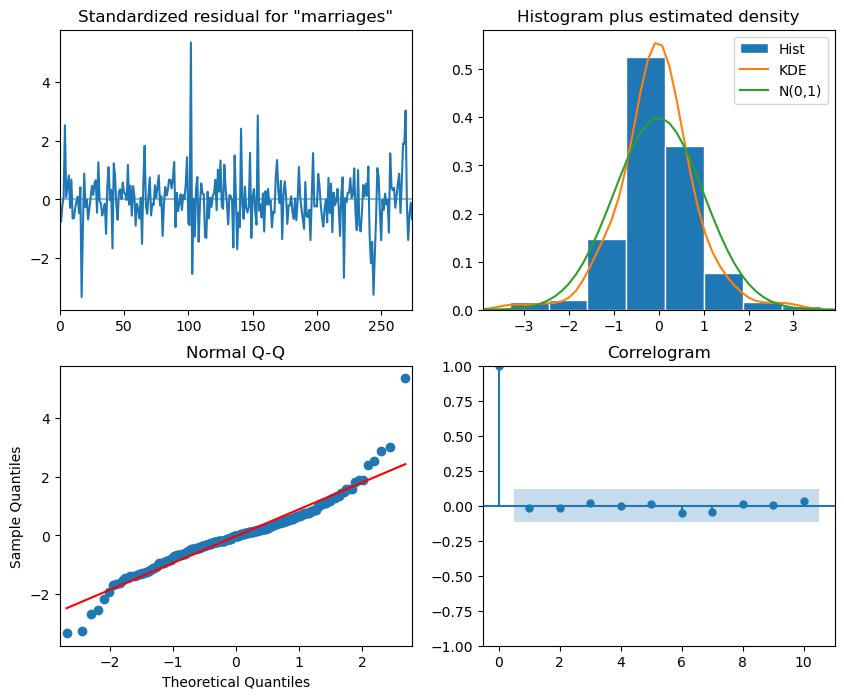

In [138]:
best_model = VARMAX(train_diff, order=(14,0))
best_model_fit = best_model.fit(disp=False)
best_model_fit.plot_diagnostics(figsize=(10,8))

In [139]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 3

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'VAR':
        marriages_pred_VAR = []
        divorces_pred_VAR = []
        births_pred_VAR = []

        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(14,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred_mar = predictions.predicted_mean.iloc[-window:]['marriages']
            oos_pred_div = predictions.predicted_mean.iloc[-window:]['divorces']
            oos_pred_bir = predictions.predicted_mean.iloc[-window:]['births']
            marriages_pred_VAR.extend(oos_pred_mar)
            divorces_pred_VAR.extend(oos_pred_div)
            births_pred_VAR.extend(oos_pred_bir)
    return marriages_pred_VAR, divorces_pred_VAR, births_pred_VAR

In [140]:
mar_pred_VAR, div_pred_VAR, births_pred_VAR = rolling_forecast(data_diff, TRAIN_LEN, HORIZON, WINDOW, 'VAR')

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [141]:
test = data_diff[-9:]

test['mar_pred_VAR'] = pd.Series()
test['mar_pred_VAR'] = data_diff.iloc[-10]['marriages'] + np.cumsum(mar_pred_VAR)

test['div_pred_VAR'] = pd.Series()
test['div_pred_VAR'] = data_diff.iloc[-10]['divorces'] + np.cumsum(div_pred_VAR)

test['bir_pred_VAR'] = pd.Series()
test['bir_pred_VAR'] = data_diff.iloc[-10]['births'] + np.cumsum(births_pred_VAR)

C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\misch\anaconda3\envs\mipt-stats\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

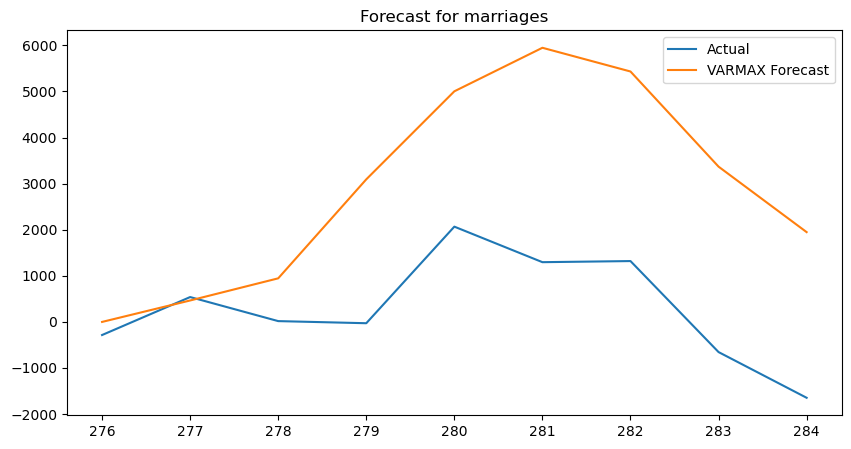

In [142]:
#Plotting all the forecasts for marriages
plt.figure(figsize=(10, 5))
plt.plot(pred_df.index, test['marriages'].values, label='Actual')
plt.plot(pred_df.index, test['mar_pred_VAR'], label='VARMAX Forecast')
plt.title('Forecast for marriages')
plt.legend()
plt.show()

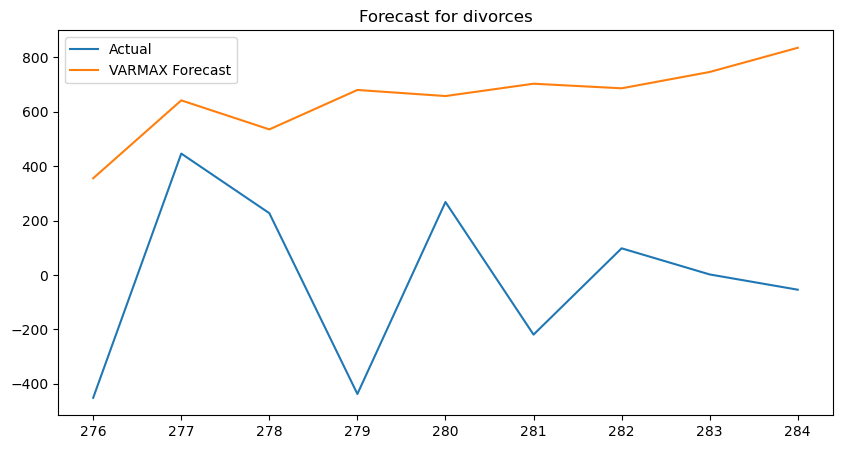

In [143]:
#Plotting all the forecasts for divorces
plt.figure(figsize=(10, 5))
plt.plot(pred_df.index, test['divorces'].values, label='Actual')
plt.plot(pred_df.index, test['div_pred_VAR'], label='VARMAX Forecast')
plt.title('Forecast for divorces')
plt.legend()
plt.show()

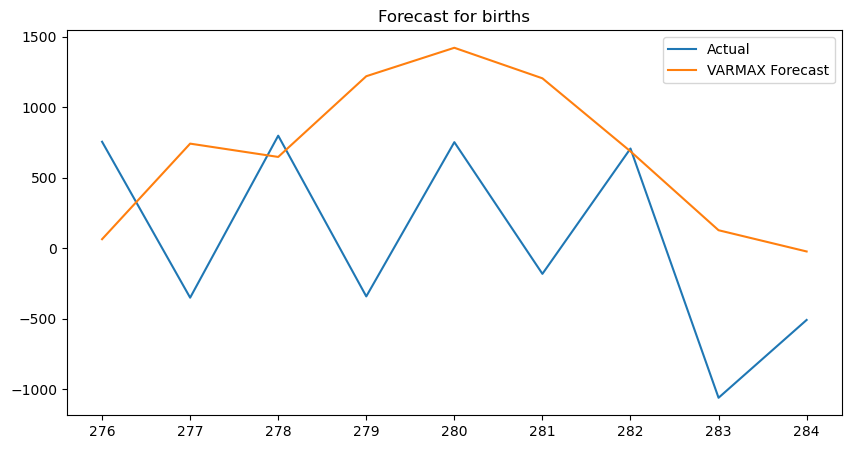

In [144]:
#Plotting all the forecasts for births
plt.figure(figsize=(10, 5))
plt.plot(pred_df.index, test['births'].values, label='Actual')
plt.plot(pred_df.index, test['bir_pred_VAR'], label='VARMAX Forecast')
plt.title('Forecast for births')
plt.legend()
plt.show()

In [145]:
mape_VARMAX_mar = mape(test['marriages'], test['mar_pred_VAR'])
print('MAPE VARMAX for marriages:', mape_VARMAX_mar)

mape_VARMAX_div = mape(test['divorces'], test['div_pred_VAR'])
print('MAPE VARMAX for divorces:', mape_VARMAX_div)

mape_VARMAX_bir = mape(test['births'], test['bir_pred_VAR'])
print('MAPE VARMAX for births:', mape_VARMAX_bir)

MAPE VARMAX for marriages: 19.967070428870148
MAPE VARMAX for divorces: 45.119424267844124
MAPE VARMAX for births: 2.1624278858637282


As we can see, VARMAX model performance is not really good

8. Compare the performance of the developed models: baselines, SARIMA, SARIMAX and VARMAX. Select an appropriate error metric.
Make conclusions.

#### Marriages:
    Historical mean error marriages:  0.5142548058647172
    Last known value error marriages:  0.2131979585435049
    SARIMA error marriages:  0.09972732838098824
    SARIMAX: 0.21444447380351703
    VARMAX: 19.967070428870148
    
 #### Divorces:
    Historical mean error divorces:  0.13626119668742034
    Last known value error divorces:  0.12848367086810777
    SARIMA error divorces:  0.055326303878105186
    SARIMAX: 0.09833105545292974
    VARMAX: 45.119424267844124
    
 #### Births:
    Historical mean error births:  0.7727902324543877
    Last known value error births:  0.783136717278698
    SARIMA error births:  0.03567543615108797
    SARIMAX: 0.17066578873645086
    VARMAX: 2.1624278858637282
    
 As it is seen, SARIMA gives the best results out of all methods